# Quantitaive Experiment Evaluation of Religion Dataset with hyperparameter tuning

To get some inspiration, e.g. seaborn, plotly and brokeh looks great https://mode.com/blog/python-data-visualization-libraries/

---

**1st Hypothesis: With use of an Importance factor in an extractive summary,we get a closer/shorter, more precise, representation of input text regard-ing to a model than without use of an IF. A number of changed predictions on these two summarization approaches will be statistically significant.**

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

import os
import sys
import pickle

%matplotlib inline

---

#### Load data from experiment

In [2]:
DATA_PATHS = {f'e{k}': f'../../data/experiments/quan-f-e{k}/latest/csv/' for k in [5, 10, 15, 20, 30, 50, 100, 1000]}

In [3]:
FACTOR = 962  # constant

In [4]:
def load_files(path_to_files):
    files_it = os.scandir(path_to_files)
    frames = {}
    
    for file in files_it:
        if file.is_file() and file.name.startswith('fm:') and file.name.endswith('.csv'):
            frame = pd.read_csv(file.path)
            
            version = file.name\
                .replace('fm:', '')\
                .replace('sen:', '')\
                .replace('part:', '')\
                .replace('.csv', '')

            _, senlen, _ = version.split('-')
            
            senlen = int(senlen)
            
            if senlen in frames:
                frames[senlen] = pd.concat([frames[senlen], frame], ignore_index=True)
            else:
                frames[senlen] = frame
        
    return dict(sorted(frames.items()))

def load_more_files(folders):
    
    ret = {}
    for folder in folders:
        ret[folder] = load_files(folders[folder])
    
    return ret

In [5]:
data = load_more_files(DATA_PATHS)

---

In [6]:
data.keys()

dict_keys(['e5', 'e10', 'e15', 'e20', 'e30', 'e50', 'e100', 'e1000'])

In [7]:
len(data)

8

In [8]:
data['e5'].keys()

dict_keys([4, 6, 8, 10, 12])

Data is a dict in dicts that have different number of top features count (LIME, from 5 to 1000) and summaries (sentences) length (SUMY, from 4 to 12)

---

#### Describe

In [9]:
data['e5'][4].columns

Index(['original-0', 'original-1', 'custom-0', 'custom-1', 'simple-0',
       'simple-1', 'trueClass'],
      dtype='object')

Columns:
 - **original[0/1]**: prediction of the examined model on the entire instance
 - **custom[0/1]**: prediction of the examined model on the custom (explanation) summaries
 - **simple[0/1]**: prediction of the examined model on the simple (TextRank) summaries without altering weights
 - **trueClass**: true class of the original instance, **(0 = atheism, 1 = christianity)**

From two predictions we are going to look at the distance between model predictions on entire texts and summaries. We narrow down predictions only for the model predicted class.

---

#### Predictions

In [10]:
def convert_to_predicted(df):
    a = df[df['original-0'] > df['original-1']][['original-0', 'custom-0', 'simple-0']].rename(columns={
        'original-0': 'original',
        'custom-0': 'custom',
        'simple-0': 'simple'
    })
    b = df[df['original-0'] < df['original-1']][['original-1', 'simple-1', 'custom-1']].rename(columns={
        'original-1': 'original',
        'custom-1': 'custom',
        'simple-1': 'simple'
    })
    return pd.concat([a, b]).reset_index(drop=True)

def convert_to_class(df, cl):
    a = df[[f'original-{cl}', f'custom-{cl}', f'simple-{cl}']].rename(columns={
        f'original-{cl}': 'original',
        f'custom-{cl}': 'custom',
        f'simple-{cl}': 'simple'
    })
    return a

Here, maybe it would be interesting to compare predictions for both classes, whether there is not a bias somewhere to one class

In [11]:
df = pd.DataFrame()
for e in data:
    for s in data[e]:
        f = convert_to_class(data[e][s], 1)
        f['featfilter'] = int(e.replace('e', ''))
        f['senlen'] = int(s)
        df = pd.concat([df, f])

In [12]:
df = df.reset_index(drop=True)

In [13]:
df.sample(3)

,original,custom,simple,featfilter,senlen
31168,0.99399,0.99230,0.97808,20,8
44049,0.99532,0.99606,0.99574,30,12
18942,1.00000,0.99999,1.00000,15,4


In [14]:
df.shape[0]

72720

In [15]:
df.dtypes

original      float64
custom        float64
simple        float64
featfilter      int64
senlen          int64
dtype: object

In [16]:
df.isna().sum()

original      0
custom        0
simple        0
featfilter    0
senlen        0
dtype: int64

In [17]:
df[df.featfilter==10].size

45450

45450 per each **top features count** parameter

In [18]:
# Normalize values to custom bounds https://stackoverflow.com/a/48109733/7875594
def normalize(values, bounds):
    if bounds['actual']['upper'] == bounds['actual']['lower']:
        return values
    return [bounds['desired']['lower'] + (abs(x) - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / 
            (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]


def process_mean(df):
    df = df.reset_index(drop=True)
    
    df['difSimple'] = df.original - df.simple
    df['difCustom'] = df.original - df.custom
    return df.difCustom.mean(), df.difSimple.mean()


def process_mse(frame):
    """
    From input dataframe returns 2 MSE errors: (1) error from custom summaries, (2) error from simple summaries
    """
    df = frame.copy(deep=True)
    
    # 1. normalize to (-1, 1)
    bounds = {
        'actual': {
            'lower':df[['original','custom','simple']].min().min(), 
            'upper':df[['original','custom','simple']].max().max()
        }, 
        'desired':{
            'lower':-1,
            'upper':1
        }
    }
    
    df['normOriginal'] = normalize(df.original, bounds)
    df['normCustom'] = normalize(df.custom, bounds)
    df['normSimple'] = normalize(df.simple, bounds)
    
    # 2. subtract textrank and custom predictions from model prediction on entire instance to get errors
    df['errorSimple'] = df.normOriginal - df.normSimple
    df['errorCustom'] = df.normOriginal - df.normCustom
    
    # 3. square errors
    df['errorSimple'] = df.errorSimple ** 2
    df['errorCustom'] = df.errorCustom ** 2
    
    # 4. find mean
    # 5. square root errors    
    return df.groupby(by=['featfilter','senlen'])[['errorSimple', 'errorCustom']].mean().apply(np.sqrt)


def process_arr(dfs, error_func):
    data = {}
    
    for d in dfs.items():
        ix = d[0]
        if error_func == 'mse':
            data[int(ix)] = process_mse(d[1])
        elif error_func == 'mean':
            data[int(ix)] = process_mean(d[1])
    return data

In [19]:
res_combinations = process_mse(df).reset_index()

In [20]:
res_combinations.sample(2)

,featfilter,senlen,errorSimple,errorCustom
0,5,4,0.529790,0.325671
38,1000,10,0.358959,0.236340


In [21]:
res_combinations=res_combinations.melt(id_vars=['senlen', 'featfilter'], value_vars=['errorSimple', 'errorCustom'], value_name='error').rename(columns={'variable': 'summary_type'})

In [22]:
res_combinations.sample(2)

,senlen,featfilter,summary_type,error
53,10,15,errorCustom,0.192202
70,4,100,errorCustom,0.396155


In [23]:
res_combinations = res_combinations.replace("errorCustom", "explanation").replace("errorSimple", "simple")

<AxesSubplot:xlabel='senlen', ylabel='error'>

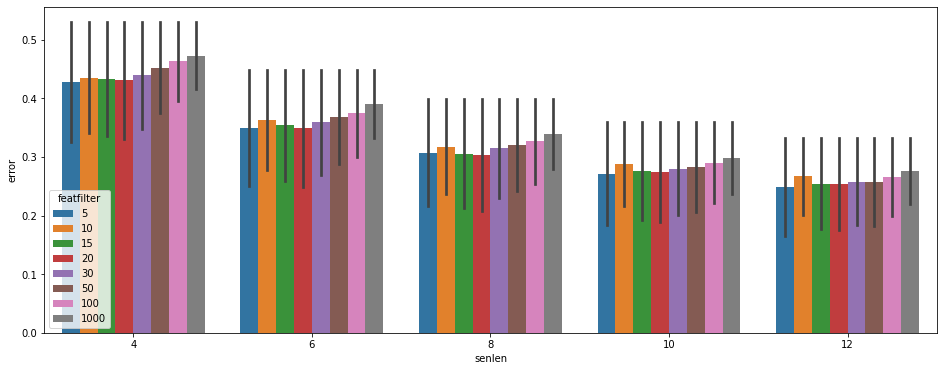

In [24]:
plt.figure(figsize=(16, 6))
sns.barplot(data=res_combinations, x="senlen", y="error", hue="featfilter")

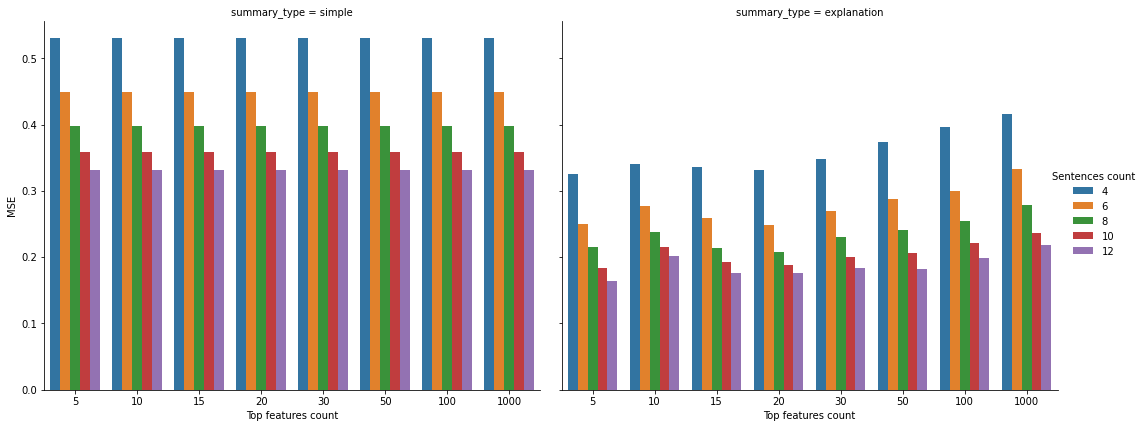

In [25]:
g = sns.catplot(data=res_combinations, x="featfilter", y="error", hue="senlen", kind="bar", col="summary_type");
g.fig.set_figwidth(16)
g.fig.set_figheight(6)
g.set_xlabels("Top features count")
g.set_ylabels("MSE")
# g.set_titles()

# plt.legend(['Explanation summaries', 'TextRank summaries', 'Entire instances', 'Selected omega'])
g._legend.set_title("Sentences count")
params = {'legend.fontsize': 'x-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

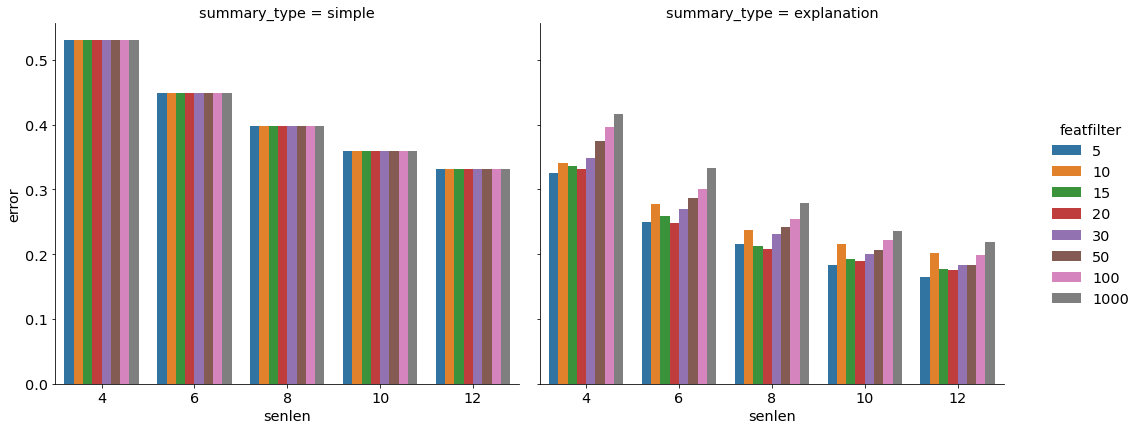

In [27]:
g = sns.catplot(data=res_combinations, x="senlen", y="error", hue="featfilter", kind="bar", col="summary_type");
g.fig.set_figwidth(16)
g.fig.set_figheight(6)

For user study we chosed summaries of 6 sentences, however, for the sake of quantitative experiment, we could choose summaries with at least 8 sentences.

---

### Statistical comparison

**1st Hypothesis: With use of an Importance factor in an extractive summary,we get a closer/shorter, more precise, representation of input text regard-ing to a model than without use of an IF. A number of changed predictions on these two summarization approaches will be statistically significant.**

In [28]:
alpha = 0.05

**6 sentences, 100 features** ~ setup from questionnaire survey

In [29]:
# get the data

dat = df[(df.senlen == 6) & (df.featfilter == 100)]

In [37]:
dat.sample()

,original,custom,simple,featfilter,senlen
56814,0.99999,0.99999,0.99666,100,6


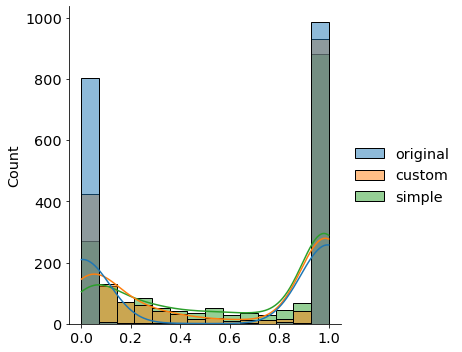

In [31]:
sns.displot(data=dat[['original', 'custom', 'simple']], kde=True)

In [32]:
dat1 = dat.melt(id_vars=['featfilter', 'senlen'], value_vars=['original', 'custom', 'simple'], var_name='type', value_name='prediction')

In [33]:
dat1.sample()

,featfilter,senlen,type,prediction
5273,100,6,simple,0.05813


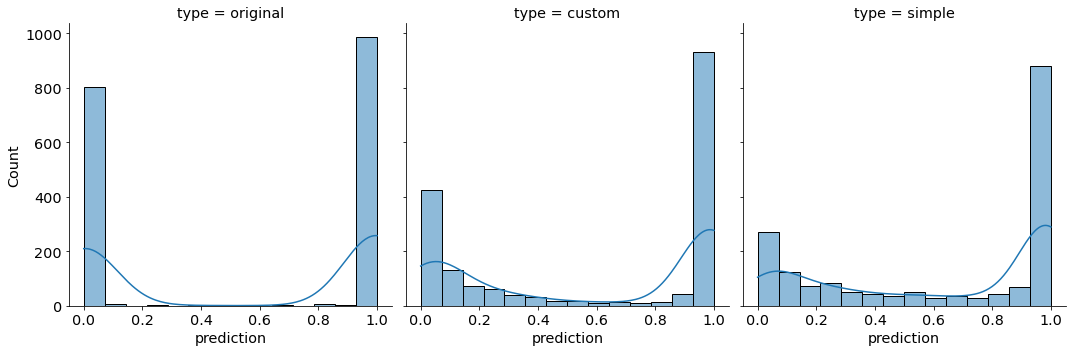

In [34]:
sns.displot(data=dat1, kde=True, col="type", x="prediction");

Lets check the differences in predictions

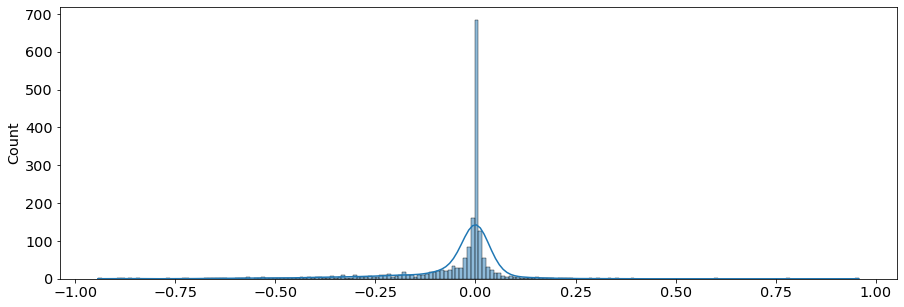

In [38]:
sns.histplot(data=(dat.original - dat.custom), bins=200, kde=True);

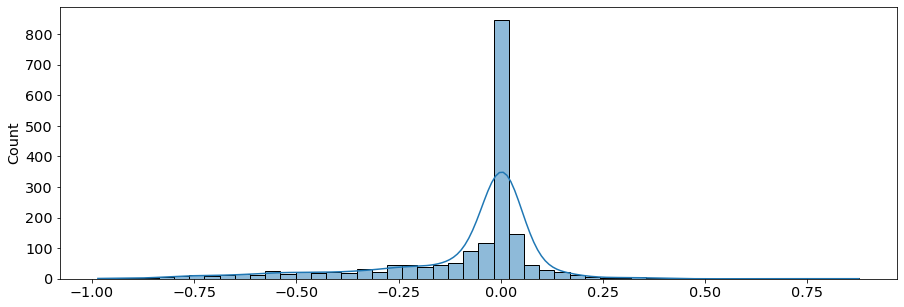

In [40]:
sns.histplot(data=(dat.original - dat.simple), bins=50, kde=True);

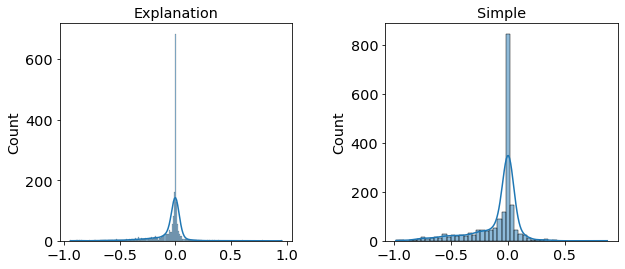

In [41]:
# for i, column in enumerate(df.columns, 1):
#     plt.subplot(3,3,i)
#     sns.histplot(df[column])
plt.figure(figsize=(10, 4));

f = plt.subplot(1, 2, 1)
g = sns.histplot(data=(dat.original - dat.custom), bins=200, kde=True);
g.title.set_text("Explanation")
plt.subplot(1, 2, 2)
g = sns.histplot(data=(dat.original - dat.simple), bins=50, kde=True);
g.title.set_text("Simple")
plt.subplots_adjust(wspace=0.4)

# plt.savefig('dist-plots.png')
# plt.savefig("dist-plots.svg", format = 'svg', dpi=300)

We clearly see that there is Gaussian distribution in both cases, however, let's use shapiro to test it 

In [42]:
custom = dat.original - dat.custom
simple = dat.original - dat.simple

In [43]:
a = pd.DataFrame({"value": np.append(custom, simple), "type": ["explanation" for _ in range(1818)] + ["simple" for _ in range(1818)]})

<AxesSubplot:ylabel='Count'>

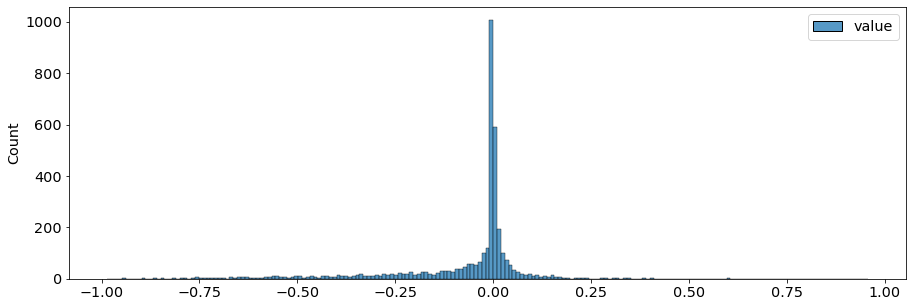

In [44]:
sns.histplot(data=a, )

In [45]:
alpha = 0.05

In [46]:
# H0 (for both test), data come from Gaussian distribution
# H1 not H0

_, pc = st.shapiro(custom)
_, ps = st.shapiro(simple)

In [47]:
pc

0.0

In [48]:
pc > alpha

False

We reject H0, not gaussian distribution

In [49]:
ps

1.401298464324817e-45

In [50]:
ps > alpha

False

The same for simple summaries

Continuing with levene test of variances in two groups

In [51]:
# H0: variance of data in two groups are the same
# H1: not H0

s, p = st.levene(custom, simple)
s, p

(85.6623764670511, 3.5493830607463034e-20)

In [52]:
p > alpha

False

In [53]:
import statsmodels.api as sm
import pylab

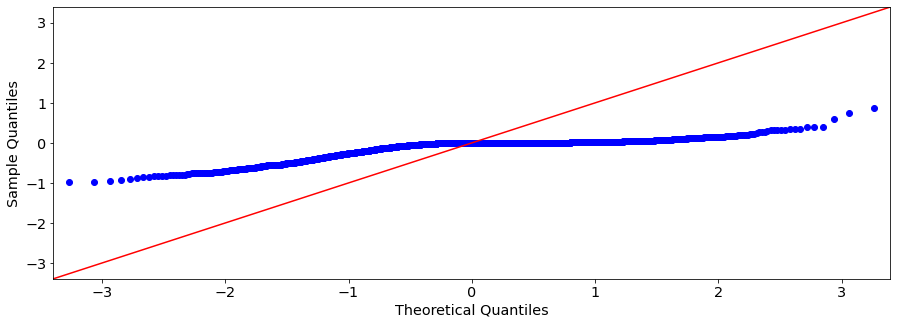

In [54]:
sm.qqplot(simple, line='45')
pylab.show()

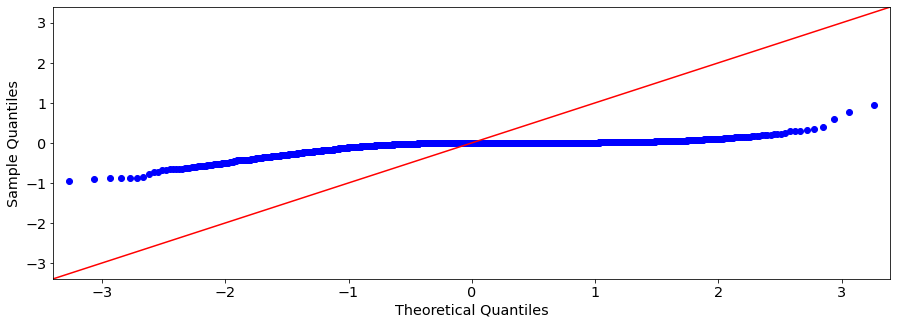

In [55]:
sm.qqplot(custom, line='45')
pylab.show()

We must use non-parametric test Mann-Whitney U test

In [56]:
# H0: data from two groups come from the same distribution
# H1: not H0

s, p = st.mannwhitneyu(custom, simple)

In [57]:
p > alpha

True

In [58]:
p

0.3255931892289944

In [59]:
print('Same distribution (fail to reject H0)')

Same distribution (fail to reject H0)


**8 sentences, 20 features** ~ compromise between mse error and summary length (people in questionnaire wanted longer sentences, we see that we could get even better results)

In [60]:
# get the data

dat = df[(df.senlen == 8) & (df.featfilter == 20)]

In [61]:
dat.sample()

,original,custom,simple,featfilter,senlen
32695,1.0,1.0,1.0,20,8


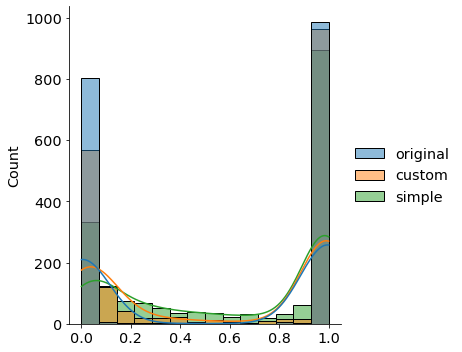

In [62]:
sns.displot(data=dat[['original', 'custom', 'simple']], kde=True)

In [63]:
dat1 = dat.melt(id_vars=['featfilter', 'senlen'], value_vars=['original', 'custom', 'simple'], var_name='type', value_name='prediction')

In [64]:
dat1.sample()

,featfilter,senlen,type,prediction
5190,20,8,simple,0.00792


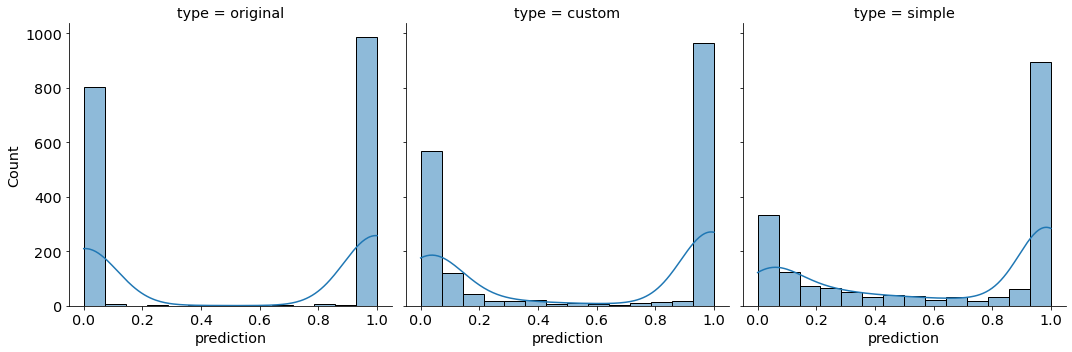

In [65]:
sns.displot(data=dat1, kde=True, col="type", x="prediction");

Lets check the differences in predictions

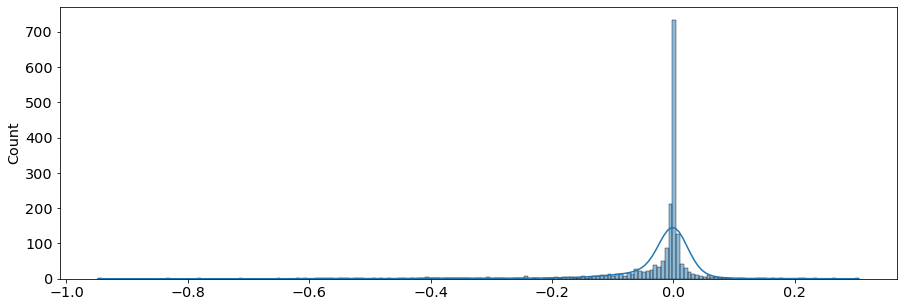

In [66]:
sns.histplot(data=(dat.original - dat.custom), bins=200, kde=True);

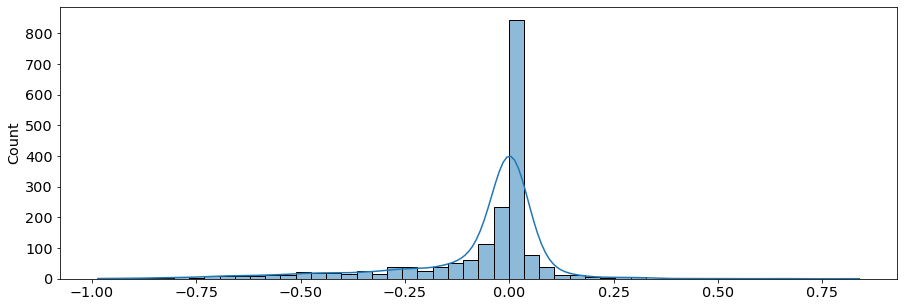

In [68]:
sns.histplot(data=(dat.original - dat.simple), bins=50, kde=True);

We clearly see that there is Gaussian distribution in both cases, however, let's use shapiro to test it 

In [69]:
custom = dat.original - dat.custom
simple = dat.original - dat.simple

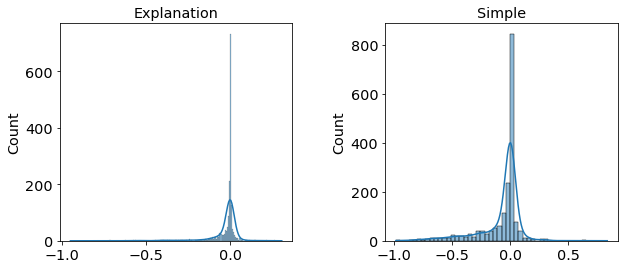

In [70]:
# for i, column in enumerate(df.columns, 1):
#     plt.subplot(3,3,i)
#     sns.histplot(df[column])
plt.figure(figsize=(10, 4));

f = plt.subplot(1, 2, 1)
g = sns.histplot(data=(dat.original - dat.custom), bins=200, kde=True);
g.title.set_text("Explanation")
plt.subplot(1, 2, 2)
g = sns.histplot(data=(dat.original - dat.simple), bins=50, kde=True);
g.title.set_text("Simple")
plt.subplots_adjust(wspace=0.4)

# plt.savefig('dist-plots.png')
# plt.savefig("dist-plots.svg", format = 'svg', dpi=300)

In [71]:
# H0 (for both test), data come from Gaussian distribution
# H1 not H0

_, pc = st.shapiro(custom)
_, ps = st.shapiro(simple)

In [72]:
print(pc)
pc > alpha

0.0


False

We reject H0, not gaussian distribution

In [73]:
print(ps)
ps > alpha

0.0


False

The same for simple summaries

Continuing with levene test of variances in two groups

In [74]:
# H0: variance of data in two groups are the same
# H1: not H0

s, p = st.levene(custom, simple)
s, p

(164.45728556673131, 7.480516112718899e-37)

In [75]:
p > alpha

False

In [76]:
import statsmodels.api as sm
import pylab

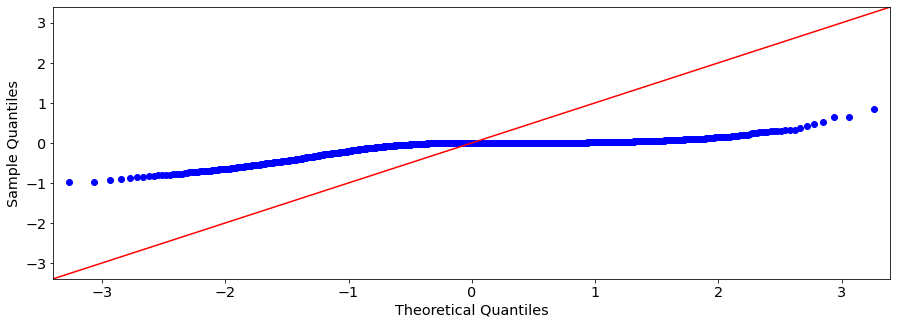

In [77]:
sm.qqplot(simple, line='45')
pylab.show()

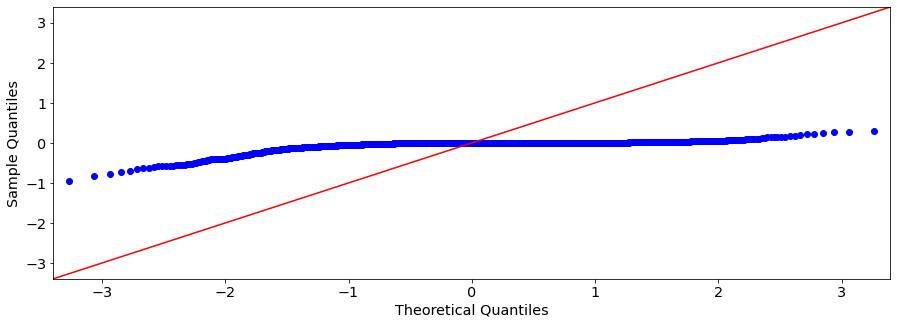

In [78]:
sm.qqplot(custom, line='45')
pylab.show()

We must use non-parametric test Mann-Whitney U test

In [79]:
# H0: data from two groups come from the same distribution
# H1: not H0

s, p = st.mannwhitneyu(custom, simple)

In [80]:
p

0.18603838595548827

In [81]:
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Same distribution (fail to reject H0)


---

**One more experiment (experimental), with MSE**

In [82]:
def process_mse_per_row(frame):
    """
    From input dataframe returns 2 MSE errors: (1) error from custom summaries, (2) error from simple summaries
    """
    df = frame.copy(deep=True)
    
    # 1. normalize to (-1, 1)
    bounds = {
        'actual': {
            'lower':df[['original','custom','simple']].min().min(), 
            'upper':df[['original','custom','simple']].max().max()
        }, 
        'desired':{
            'lower':-1,
            'upper':1
        }
    }
    
    df['normOriginal'] = normalize(df.original, bounds)
    df['normCustom'] = normalize(df.custom, bounds)
    df['normSimple'] = normalize(df.simple, bounds)
    
    # 2. subtract textrank and custom predictions from model prediction on entire instance to get errors
    df['errorSimple'] = df.normOriginal - df.normSimple
    df['errorCustom'] = df.normOriginal - df.normCustom
    
    # 3. square errors
    df['errorSimple'] = df.errorSimple ** 2
    df['errorCustom'] = df.errorCustom ** 2

    return df[['original','custom','simple', 'errorSimple', 'errorCustom']]

In [83]:
# get the data

dat = df[(df.senlen == 8) & (df.featfilter == 20)]

In [84]:
dat.sample()

,original,custom,simple,featfilter,senlen
32099,0.00107,0.14586,0.41263,20,8


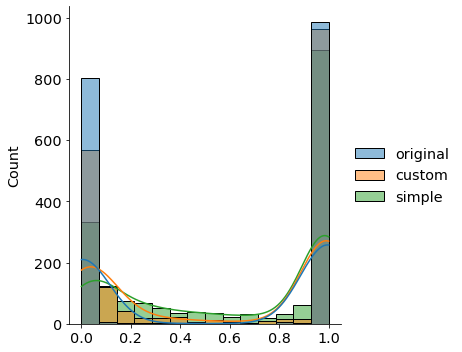

In [85]:
sns.displot(data=dat[['original', 'custom', 'simple']], kde=True)

In [86]:
dat1 = dat.melt(id_vars=['featfilter', 'senlen'], value_vars=['original', 'custom', 'simple'], var_name='type', value_name='prediction')

In [87]:
dat1.sample()

,featfilter,senlen,type,prediction
767,20,8,original,0.99456


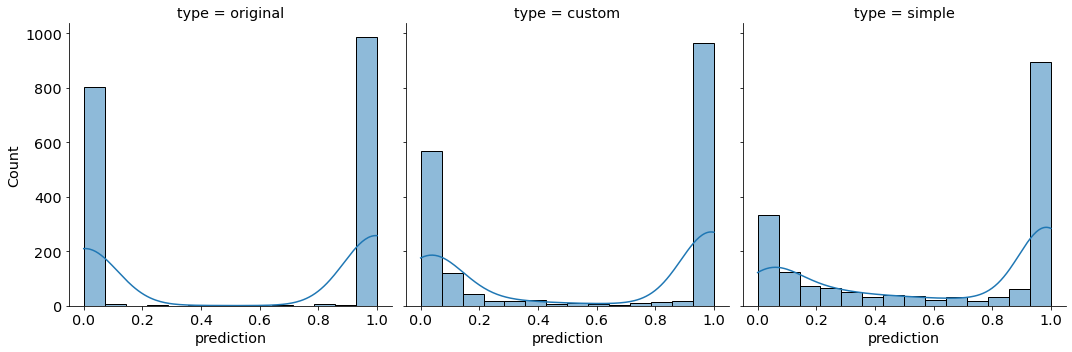

In [88]:
sns.displot(data=dat1, kde=True, col="type", x="prediction");

In [89]:
mse = process_mse_per_row(dat)

In [90]:
mse

,original,custom,simple,errorSimple,errorCustom
30906,0.00097,0.00433,0.09192,3.308761e-02,4.515840e-05
30907,0.00543,0.00800,0.00869,4.251040e-05,2.641960e-05
30908,0.00543,0.01036,0.04477,6.190542e-03,9.721960e-05
30909,0.00542,0.03503,0.16025,9.588932e-02,3.507008e-03
30910,0.00543,0.07217,0.52674,1.087056e+00,1.781691e-02
...,...,...,...,...,...
32719,0.99398,0.92264,0.94500,9.596162e-03,2.035758e-02
32720,0.99557,0.99668,0.99731,1.211040e-05,4.928400e-06
32721,0.99397,0.98433,0.96019,4.564354e-03,3.717184e-04
32722,0.99397,0.98729,0.98574,2.709316e-04,1.784896e-04


In [91]:
# mse.melt(id_vars=['errorSimple', 'errorCustom'], value_vars=['original', 'custom', 'simple'], var_name='type', value_name='prediction')
mse = mse.melt(value_vars=['errorSimple', 'errorCustom'], value_name='error', var_name='mse')

In [92]:
mse.sample(2)

,mse,error
252,errorSimple,0.005435
2484,errorCustom,0.000347


<AxesSubplot:xlabel='error', ylabel='Count'>

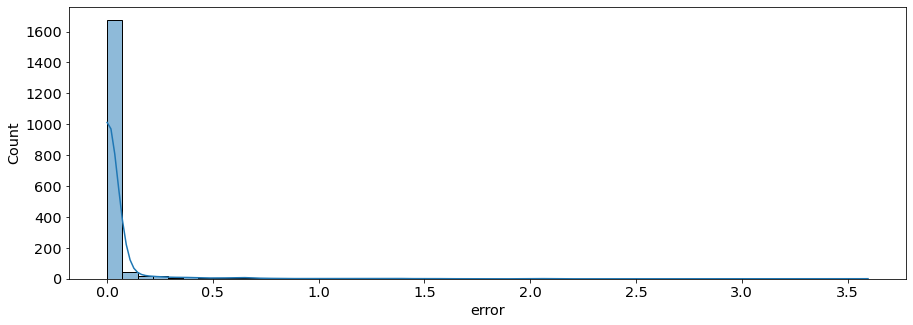

In [93]:
sns.histplot(data=mse.error[mse.mse=='errorCustom'], bins=50, kde=True)

<AxesSubplot:xlabel='error', ylabel='Count'>

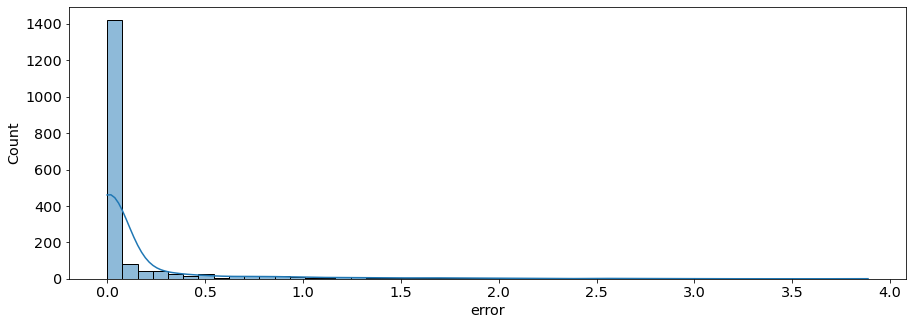

In [94]:
sns.histplot(data=mse.error[mse.mse=='errorSimple'], bins=50, kde=True)

In [95]:
mse = mse.rename(columns={'mse': 'type'})

<AxesSubplot:xlabel='error', ylabel='type'>

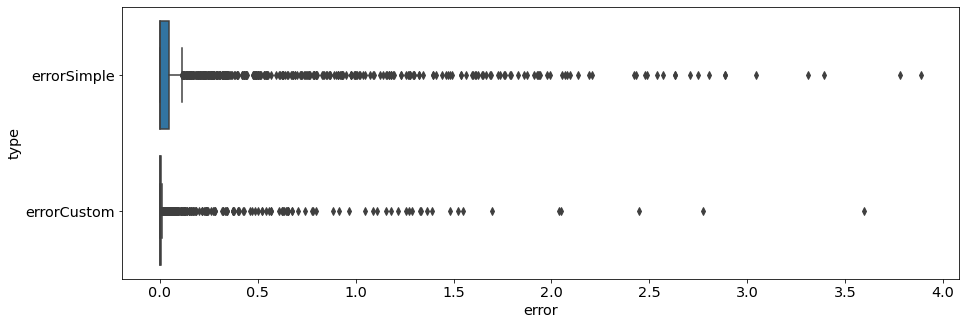

In [96]:
sns.boxplot(data=mse, x="error", y="type")

In [98]:
st.shapiro(mse.error[mse.type=='errorSimple'])

ShapiroResult(statistic=0.4149940609931946, pvalue=0.0)

In [99]:
st.shapiro(mse.error[mse.type=='errorCustom'])

ShapiroResult(statistic=0.20996099710464478, pvalue=0.0)

Not even walked around Gaussian based on p

In [100]:
s, p =st.mannwhitneyu(mse.error[mse.type=='errorSimple'], mse.error[mse.type=='errorCustom'])
s, p

(1305560.5, 2.2849616374439415e-28)

In [101]:
p > alpha

False

In [103]:
if p > alpha:
    print('Same mean values (fail to reject H0)')
else:
    print('Different mean values (reject H0)')

Different mean values (reject H0)
